# Example of pyhf interactions with likelihoods

In [1]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
with open("example.json") as file:
    parsed_spec = json.load(file)
    
print(json.dumps(parsed_spec, indent=2, sort_keys=True))

{
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "data": [
            20.0,
            10.0
          ],
          "modifiers": [
            {
              "data": null,
              "name": "mu",
              "type": "normfactor"
            }
          ],
          "name": "signal"
        },
        {
          "data": [
            50.0,
            63.0
          ],
          "modifiers": [
            {
              "data": [
                5.0,
                12.0
              ],
              "name": "uncorr_bkguncrt",
              "type": "shapesys"
            }
          ],
          "name": "background"
        }
      ]
    }
  ],
  "measurements": [
    {
      "config": {
        "parameters": [],
        "poi": "mu"
      },
      "name": "Measurement"
    }
  ],
  "observations": [
    {
      "data": [
        55.0,
        62.0
      ],
      "name": "singlechannel"
    }
  ],
  "version": "1.0.0"
}


From the parsed data, we construct a probability density function (p.d.f). As the model includes systematics a number of implied "auxiliary measurements" must be added to the observed data distribution.

In [3]:
pdf = pyhf.Model({'channels': parsed_spec['channels'],
                  'parameters': parsed_spec['measurements'][0]['config']['parameters']},
                 poiname = 'mu')

workspace = pyhf.Workspace(parsed_spec)
obs_data = workspace.observations['singlechannel']
data = obs_data + pdf.config.auxdata

## Interval Estimation (Computing Upper Limits on µ)

A common task in the statistical evaluation of High Energy Physics data analyses is the estimation of confidence intervals of parameters of interest. The general strategy is to perform a series of hypothesis tests and then *invert* the tests in order to obtain an interval with the correct coverage properties.

A common figure of merit is a modified p-value, CLs. Here we compute an upper limit based on a series of CLs tests.

In [4]:
def plot_results(ax, test_mus, cls_obs, cls_exp, test_size=0.05):
    ax.plot(mu_tests, cls_obs, c = 'k')
    for i,c in zip(range(5),['k','k','k','k','k']):
        ax.plot(mu_tests, cls_exp[i], c = c, linestyle = 'dotted' if i!=2 else 'dashed')
    ax.fill_between(test_mus,cls_exp[0],cls_exp[-1], facecolor = 'y')
    ax.fill_between(test_mus,cls_exp[1],cls_exp[-2], facecolor = 'g')
    ax.plot(test_mus,[test_size]*len(test_mus), c = 'r')
    ax.set_ylim(0,1)

In [5]:
def invert_interval(test_mus, cls_obs, cls_exp, test_size=0.05):
    crossing_test_stats = {'exp': [], 'obs': None}
    for cls_exp_sigma in cls_exp:
        crossing_test_stats['exp'].append(
            np.interp(
                test_size, list(reversed(cls_exp_sigma)), list(reversed(test_mus))
            )
        )
    crossing_test_stats['obs'] = np.interp(
        test_size, list(reversed(cls_obs)), list(reversed(test_mus))
    )
    return crossing_test_stats

In [6]:
mu_tests = np.linspace(0, 2, 2*16)
hypo_tests = [pyhf.utils.hypotest(mu, data, pdf, pdf.config.suggested_init(), pdf.config.suggested_bounds(),
                                 return_expected_set=True, return_test_statistics=True)
              for mu in mu_tests]

test_stats = np.array([test[-1][0] for test in hypo_tests]).flatten()
cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

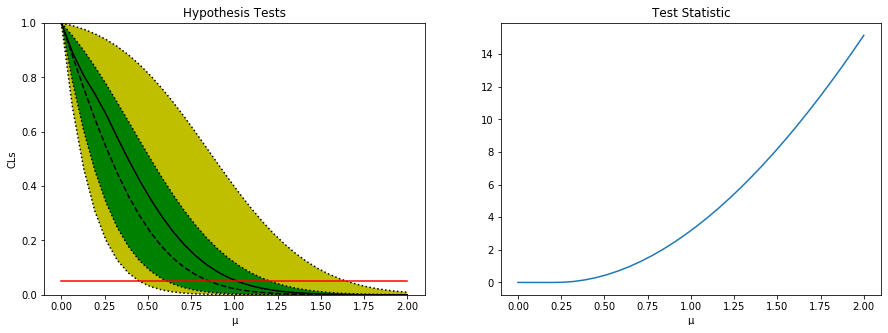

In [7]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax1.set_title(u'Hypothesis Tests')
ax1.set_ylabel(u'CLs')
ax1.set_xlabel(u'µ')
ax1 = plot_results(ax1, mu_tests, cls_obs, cls_exp);

ax2.set_title(u'Test Statistic')
ax2.set_xlabel(u'µ')
ax2.plot(mu_tests,test_stats);

In [8]:
results = invert_interval(mu_tests, cls_obs, cls_exp)

print('Observed Limit: {:.2f}'.format(results['obs']))
print('-----')
for i, n_sigma in enumerate(np.arange(-2,3)):
    print('Expected Limit{}: {:.3f}'.format('' if n_sigma==0 else '({} σ)'.format(n_sigma),results['exp'][i]))

Observed Limit: 1.02
-----
Expected Limit(-2 σ): 0.451
Expected Limit(-1 σ): 0.612
Expected Limit: 0.856
Expected Limit(1 σ): 1.208
Expected Limit(2 σ): 1.651
